In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

import thinkbayes
from thinkbayes import Pmf
from thinkbayes import Suite
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# 의사 결정 분석
___
## 1. '$The Price is Right$*(그 가격이 적당해요)*' 문제

>- A와 B가 진열대 위 물건의 가격을 맞추는 게임에 참가
>- 진열대 가격을 넘기 않는 한도 내에서 가장 가까운 가격을 부르는 사람이 승리
>- A는 \$26,000을 예상하였고 실제 가격은 \$25,347
>- B는 \$21,500을 예상하였고 실제 가격은 \$21,578
>- B는 -\$78 차이로 승리했을 뿐 아니라 예상가와 금액차이가 \$250 보다 작아 A의 진열대 물건까지 확보(게임룰)

- 베이지안 사고 방식을 갖고 있는 사람들에게, 위 시나리오는 다음 3가지 질문을 던짐
> 1. 결과를 보기 전에, 진열대 가격에 대한 사전분포를 얼마나 믿고 있었을까?
> 2. 결과 확인 후 가격에 대한 믿음의 사후분포가 바뀌었을까?
> 3. 사후분포에 따르면 참가자는 얼마를 부르는 것이 유리한가?

___
## 2. 사전 분포

- '$The Price is Right$'의 [2011년](http://thinkbayes.com/showcases.2011.csv), [2012년](http://thinkbayes.com/showcases.2012.csv) 시즌 별 각 회차의 금액과 참가자들의 예상가는 링크 에서 확인 가능
- KDE로 다듬어진 분포는 아래 그래프에서 확인 가능

In [2]:
biddings = pd.merge(pd.read_csv('data/showcases.2011.csv')[2:4],pd.read_csv('data/showcases.2012.csv')[1:3], on = 'Unnamed: 0')
biddings.index = biddings['Unnamed: 0']
biddings.index.name = ''
biddings = biddings.iloc[:,1:]
biddings = biddings.astype(int)
biddings = biddings.T

Text(0,0.5,'PDF')

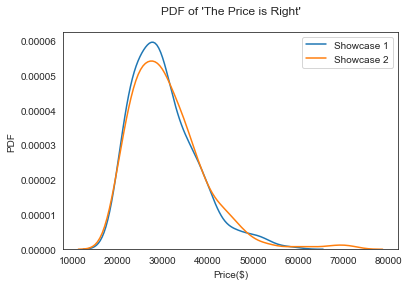

In [3]:
sns.set_style('white')
sns.distplot(biddings['Showcase 1'], label = 'Showcase 1', hist = False)
sns.distplot(biddings['Showcase 2'], label = 'Showcase 2', hist = False)
plt.legend()
plt.title("PDF of 'The Price is Right'\n")
plt.xlabel("Price($)")
plt.ylabel('PDF')
#plt.set(xlabel= 'Price($)', ylabel = 'PDF')

___
## 3. 확률 밀도 함수 (PDF)

- 그동안은 이산형 밀도 함수인 PMF를 다뤄왔고, 각 Pmf object별로 확률값을 반환함
- **연속확률함수(PDF)**은 연속형 PMF로 보통 함수 형식으로 표시함
- 다음은 평균이 0이고 표준편차가 1인 가우시간 분포의 PDF를 나타낸 것 $N(0, 1)$
$$
f(x) = \frac{1}{\sqrt{2\pi}}exp(-x^2/2)
$$

- 위 함수는 주어진 $x$에 대한 확률 밀도를 계산
- PDF는 값이 클수록 근사값에 가까워지지만, 0부터 무한대까지 값을 가질 수 있어 확률로 볼 수는 없음
- 다만 이를 연속적 범위로 적분한다면 확률로 반환은 가능

___
## 4. PDF 나타내기

- thinkbayes는 `Pdf`라는 클래스를 통해 **추상형** 인터페이스 구축
- `Pdf` 인터페이스는 `Density`와 `MakePmf` 두가지 방법을 포함
```python
class Pdf(object):
    
    def Density(self, x):
        raise UnimplmentedMethodException()
    
    def MakePmf(self, xs):
        pmf = Pmf()
        for  x  in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf
```

- `Density`는 값 x를 받아서 이에 해당하는 확률 밀도를 반환
- `MakePmf`는 PDF의 이산형 추정값을 반환

- 가우시안 PDF 같은 경우는 간단한 수학 함수로 정의되어 구현하기도 쉬움 (실생활에서 빈번하게 나타나기도 함)
- 하지만 실제 데이터의 분포를 다른 함수로 나타낼 수 있다는 보장은 없으며, **전체 PDF를 추정하기 위해 샘플을 사용**
- $The Price is Right$ 예제에서는 1회차에 대해 313개의 데이터가 있으며, 순서대로 나열할 시 아래같이 나타남

In [5]:
biddings.sort_values('Showcase 1').head()

,Showcase 1,Showcase 2
Jan. 13,19563,33551
Dec. 23,19612,23084
Apr. 17,20408,34453
Mar. 20_x,20418,25541
Jan. 16_x,20418,29524


- 이 경우 `[19563, 19612, 20408, 20418, 20418]`의 관측값이 있으며, 19564가 관측되지 않았다고 해서 나올 일이 없다고 판단내릴 근거가 없음
- 배경 지식을 기반으로 범위 내 값일 가능성이 있는 모든 값을 예상해야 하며, 이는 곧 **PDF 곡선을 부드럽게 유추하는 과정**으로 볼 수 있음
- **KDE(커널 밀도 추정)**d은 샘플로 데이터에 적합한 추정PDF를 찾아내는 것임